# Arginine-glutamic acid dipeptide repeats (RERE)

The Arginine-glutamic acid dipeptide repeats (RERE) RERE gene encodes a nuclear receptor coregulator that positively regulates retinoic acid signaling [Fregeau et al., 2016](https://pubmed.ncbi.nlm.nih.gov/27087320/). A high percentage of RERE pathogenic variants affect a 21 amino acid (amino acids 1425–1445), histidine-rich region of the Atrophin-1 domain [Jordan et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29330883/). The authors noted that Of the 19 individuals with NEDBEH described here and by Fregeau et al. (2016), nine (47%) carry sequence variants that affect a histidine-rich region of the Atrophin-1 domain that spans 21 amino acids (1425– 1445). The amino acid sequence in this region is 100% conserved down to Xenopus and zebrafish, but the functional significance of this domain is currently unknown.

Let us try to reproduce Table 3 of https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5903952/
To do this, we will want to use (for instance)  Abnormal brain morphology HP:0012443 for "Brain anomalies", and use the MTC feature that tests only one term at a time (this will mean no Bonferroni is applied, just as in the original publication).  

Take a look at "analysis_config.specify_terms_strategy()"
Do this once for each of the items in Table 3 with the appropriate HPO term.
Presumably, we will also not achieve statistical significance, but if we get a comparable result as the authors, this will be fine.

As a stretch goal, we can figure out how to do "Number of defects per individual"


In [27]:
import hpotk
import gpsea

from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.5.1.dev0


### RERE
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for RERE.

In [28]:
gene_symbol = 'RERE'
mane_tx_id = 'NM_012102.4'
mane_protein_id = 'NP_036234.3' # FYVE, RhoGEF and PH domain-containing protein 1 [Homo sapiens]

In [29]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.19'  # Update, if necessary
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(phenopackets)} phenopackets')

Loaded 19 phenopackets


In [30]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')

Individuals Processed:   0%|          | 0/19 [00:00<?, ?individuals/s]

Individuals Processed: 100%|██████████| 19/19 [00:02<00:00,  7.10individuals/s]
Loaded 19 individuals


In [31]:
qc.summarize()

Validated under permissive policy
No errors or warnings were found


In [32]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
report = cv.process(cohort, transcript_id=mane_tx_id)
display(report)

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,17
Intellectual disability,HP:0001249,17
Autistic behavior,HP:0000729,12
Hypotonia,HP:0001252,8
Thin corpus callosum,HP:0033725,7
Reduced cerebral white matter volume,HP:0034295,6
Short stature,HP:0004322,5
Ventricular septal defect,HP:0001629,5
Hypertelorism,HP:0000316,4
Coloboma,HP:0000589,4


In [33]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVariantViewer


pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)

viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
html_prot = viewer.process(cohort)
display(html_prot)

Name,Type,Coordinates,Count,Variants
Disordered,REGION,1 - 90,1,p.Ser84ValfsTer4
BAH,DOMAIN,103 - 283,0,
ELM2,DOMAIN,284 - 387,1,p.Leu369CysfsTer16
SANT,DOMAIN,391 - 443,0,
Disordered,REGION,464 - 495,1,p.Val471Ile
Disordered,REGION,542 - 1133,3,p.Pro1041LeufsTer40; p.Thr758SerfsTer36; p.Gln760Ter
Disordered,REGION,1162 - 1246,0,


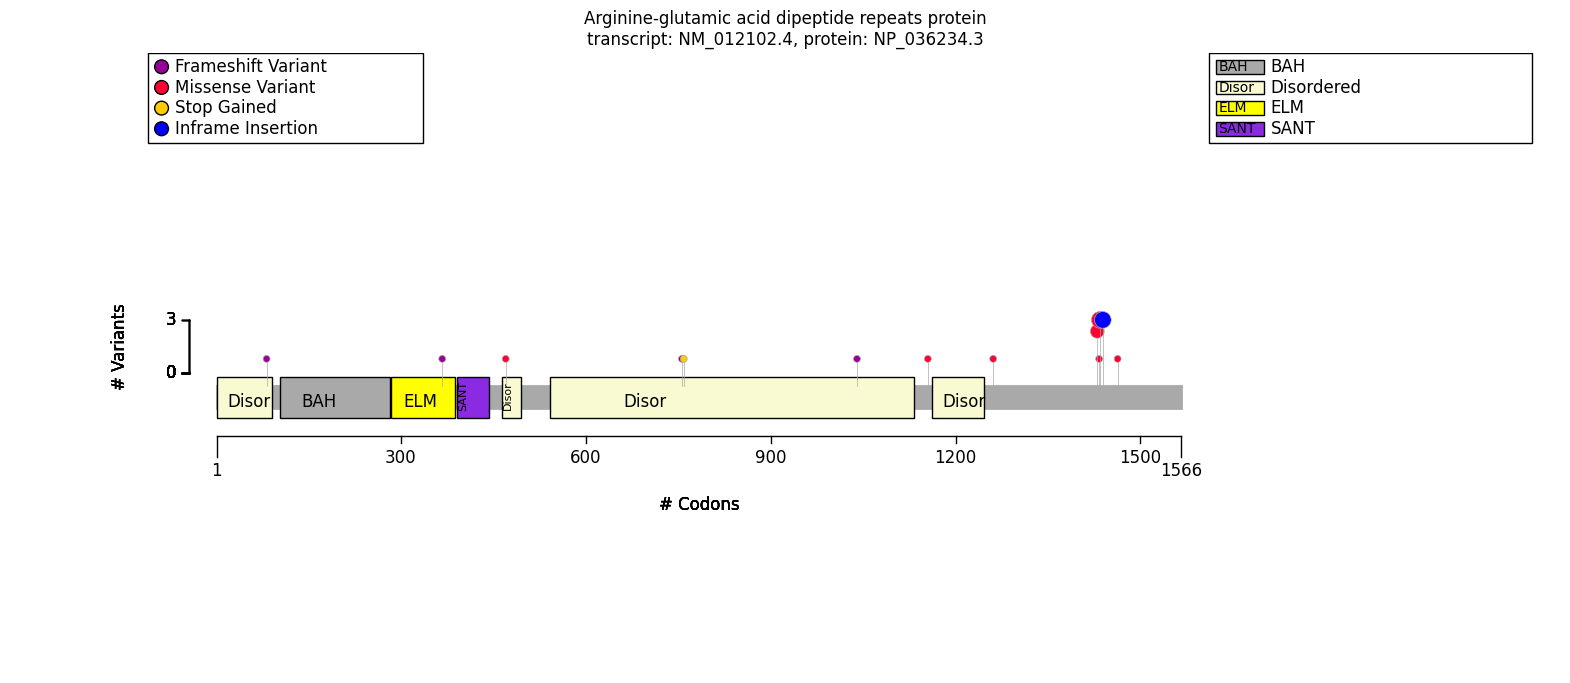

In [34]:
from gpsea.view import ProteinVisualizer

drawer = ProteinVisualizer()
_ = drawer.draw_fig(pvis=pvis)

In [35]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
report = viewer.process(cohort)
display(report)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
1_8358216_8358216_T_TGGTGGA,c.4313_4318dup,p.Leu1438_His1439dup,21,inframe insertion,3
1_8358242_8358242_G_T,c.4293C>A,p.His1431Gln,21,missense,1
1_8358231_8358231_T_C,c.4304A>G,p.His1435Arg,21,missense,1
1_8361236_8361236_C_CCCTGGAGGAGCTGAGGAGGGAG,c.2249_2270dup,p.Thr758SerfsTer36,19,frameshift,1
1_8358750_8358750_G_C,c.3785C>G,p.Pro1262Arg,21,missense,1
1_8365848_8365848_C_T,c.1411G>A,p.Val471Ile,14,missense,1
1_8358232_8358232_G_A,c.4303C>T,p.His1435Tyr,21,missense,1
1_8358242_8358242_G_C,c.4293C>G,p.His1431Gln,21,missense,1
SO:1000029_HGNC:9965_RERE,SV involving RERE,p.?,,chromosomal deletion,1
1_8656049_8656049_C_CT,c.248dup,p.Ser84ValfsTer4,3,frameshift,1


In [50]:
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant
from gpsea.model import VariantEffect

lof_effects = (
    VariantEffect.TRANSCRIPT_ABLATION,
    VariantEffect.FRAMESHIFT_VARIANT,
    VariantEffect.START_LOST,
    VariantEffect.STOP_GAINED,
)
lof_mutation = VariantPredicates.any(VariantPredicates.variant_effect(eff, mane_tx_id) for eff in lof_effects)
lof_predicate = autosomal_dominant(lof_mutation)

In [58]:
from gpsea.model.genome import Region

atrophin_dom = VariantPredicates.region(Region(1425, 1445), mane_tx_id)
atrophin_pred = autosomal_dominant(atrophin_dom)

In [51]:
from gpsea.analysis.pscore import CountingPhenotypeScorer
from gpsea.analysis.pscore.stats import MannWhitneyStatistic
from gpsea.analysis.pscore import PhenotypeScoreAnalysis

select_hpo = ("HP:0012443", "HP:0012372","HP:0001627","HP:0012210", "HP:0000407")

scorer = CountingPhenotypeScorer.from_query_curies(hpo, select_hpo)
score_stats = MannWhitneyStatistic()
score_analysis = PhenotypeScoreAnalysis(score_stats)

In [52]:
score_results = score_analysis.compare_genotype_vs_phenotype_score(cohort, lof_predicate, scorer)
score_results.pval

0.004993705110263896

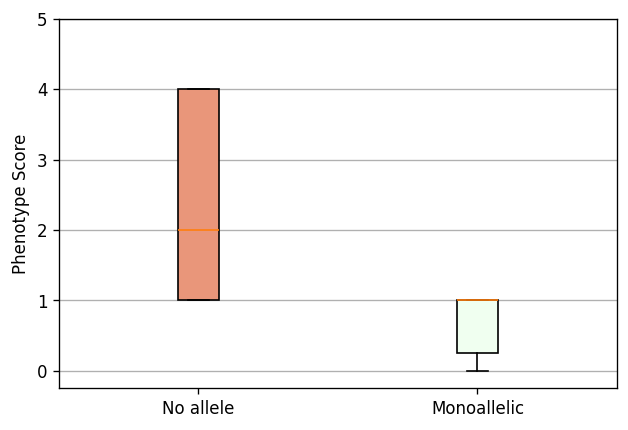

In [56]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize = (6,4), dpi = 120)
score_results.plot_boxplots(lof_predicate, ax)
_= ax.grid(axis="y")
_= ax.set(ylabel="Phenotype Score", ylim=(-0.25, 5))

In [59]:
score_results = score_analysis.compare_genotype_vs_phenotype_score(cohort, atrophin_pred, scorer)
score_results.pval

0.05384843955575239

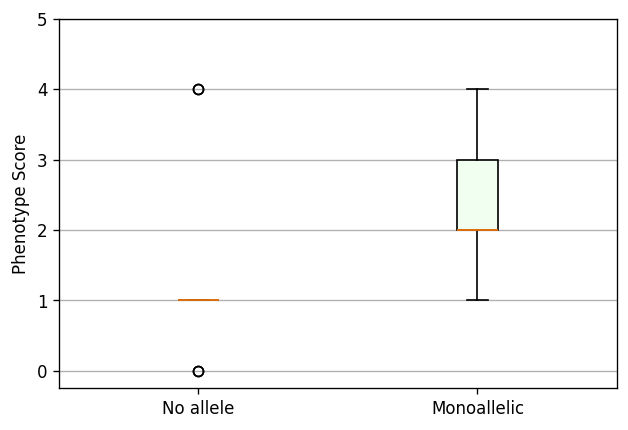

In [60]:
fig, ax = plt.subplots(figsize = (6,4), dpi = 120)
score_results.plot_boxplots(atrophin_pred, ax)
_= ax.grid(axis="y")
_= ax.set(ylabel="Phenotype Score", ylim=(-0.25, 5))

In [61]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant

is_frameshift = VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)
gt_predicate = autosomal_dominant(is_frameshift)

In [65]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [66]:
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

In [67]:
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [73]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

In [74]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

What is the genotype group                         No allele          \
                                                       Count Percent   
Thin corpus callosum [HP:0033725]                        7/7    100%   
Broad eyebrow [HP:0011229]                              0/15      0%   
Reduced cerebral white matter volume [HP:0034295]        6/6    100%   
Macrocephaly [HP:0000256]                               0/14      0%   
Poor suck [HP:0002033]                                   0/7      0%   
Downslanted palpebral fissures [HP:0000494]             1/15      7%   
Hypertelorism [HP:0000316]                              2/15     13%   
Short stature [HP:0004322]                               5/8     62%   
Global developmental delay [HP:0001263]                14/14    100%   
Intellectual disability [HP:0001249]                   14/14    100%   
Ventriculomegaly [HP:0002119]                            4/7     57%   
Cerebellar vermis hypoplasia [HP:0001320]                3/7     43%   
Intrauterine growth retardation [HP:0001511]             3/8     38%   
Sensorineural hearing impairment [HP:0000407]           4/14     29%   
Coloboma [HP:0000589]                                   4/15     27%   
Scoliosis [HP:0002650]                                  2/15     13%   
Triangular face [HP:0000325]                            2/15     13%   
Epicanthus [HP:0000286]                                 2/15     13%   
Hypotonia [HP:0001252]                                  7/15     47%   
Abnormal pinna morphology [HP:0000377]                   6/6    100%   
Choanal atresia [HP:0000453]                            3/15     20%   
Neurodevelopmental delay [HP:0012758]                  14/14    100%   
Neurodevelopmental abnormality [HP:0012759]            14/14    100%   
Abnormal axial skeleton morphology [HP:0009121]          6/6    100%   
Abnormal ocular adnexa morphology [HP:0030669]           5/5    100%   
Morphological central nervous system abnormalit...       9/9    100%   
Autistic behavior [HP:0000729]                           9/9    100%   
Atypical behavior [HP:0000708]                         10/10    100%   
Ventricular septal defect [HP:0001629]                   4/8     50%   
Abnormal cardiac septum morphology [HP:0001671]          6/6    100%   
Hypospadias [HP:0000047]                                 2/6     33%   
Abnormal muscle tone [HP:0003808]                        8/8    100%   
Patent foramen ovale [HP:0001655]                        2/8     25%   
Clinodactyly of the 5th finger [HP:0004209]              2/8     25%   
Abnormal digit morphology [HP:0011297]                   6/6    100%   
Abnormal appendicular skeleton morphology [HP:0...       6/6    100%   
Microphthalmia [HP:0000568]                              2/7     29%   
Deeply set eye [HP:0000490]                             3/15     20%   
Vesicoureteral reflux [HP:0000076]                      3/15     20%   
Broad thumb [HP:0011304]                                 2/8     25%   
Single transverse palmar crease [HP:0000954]             2/7     29%   

What is the genotype group                         Monoallelic          \
                                                         Count Percent   
Thin corpus callosum [HP:0033725]                          0/2      0%   
Broad eyebrow [HP:0011229]                                 2/4     50%   
Reduced cerebral white matter volume [HP:0034295]          0/2      0%   
Macrocephaly [HP:0000256]                                  2/4     50%   
Poor suck [HP:0002033]                                     2/3     67%   
Downslanted palpebral fissures [HP:0000494]                2/4     50%   
Hypertelorism [HP:0000316]                                 2/4     50%   
Short stature [HP:0004322]                                 0/3      0%   
Global developmental delay [HP:0001263]                    3/4     75%   
Intellectual disability [HP:0001249]                       3/4     75%   
Ventriculomegal